# 🌸 Iris Classification Experiment

This notebook demonstrates the complete MLOps workflow for Iris flower classification:
1. Data preparation and exploratory analysis
2. Model training and evaluation
3. Experiment tracking with MLflow
4. Model registration and versioning

## 📦 Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from datetime import datetime

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [11]:
## 🔧 Configure MLflow Artifact Store (MinIO)

import os

# NOTE: These are common default credentials for MinIO. 
# Please verify them against your docker-compose or deployment configuration.
os.environ["AWS_ACCESS_KEY_ID"] = "minioadmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minioadmin"

# This should point to your MinIO container's exposed port
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://127.0.0.1:9010"

print("✅ MLflow S3 configuration set for MinIO.")
print(f"   - Endpoint URL: {os.environ['MLFLOW_S3_ENDPOINT_URL']}")
print("   - Access Key: 'minioadmin' (Please verify this is correct)")


✅ MLflow S3 configuration set for MinIO.
   - Endpoint URL: http://127.0.0.1:9010
   - Access Key: 'minioadmin' (Please verify this is correct)


## 📊 Data Preparation and Exploration

In [2]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Create DataFrame for easier manipulation
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y
df['target_name'] = df['target'].map({i: name for i, name in enumerate(iris.target_names)})

# Display basic information
print("📈 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Features: {list(iris.feature_names)}")
print(f"Classes: {list(iris.target_names)}")
print("\n📋 First few rows:")
display(df.head())

print("\n📊 Dataset Statistics:")
display(df.describe())

📈 Dataset Overview:
Shape: (150, 6)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa', 'versicolor', 'virginica']

📋 First few rows:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa



📊 Dataset Statistics:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


🎯 Class Distribution:
target_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


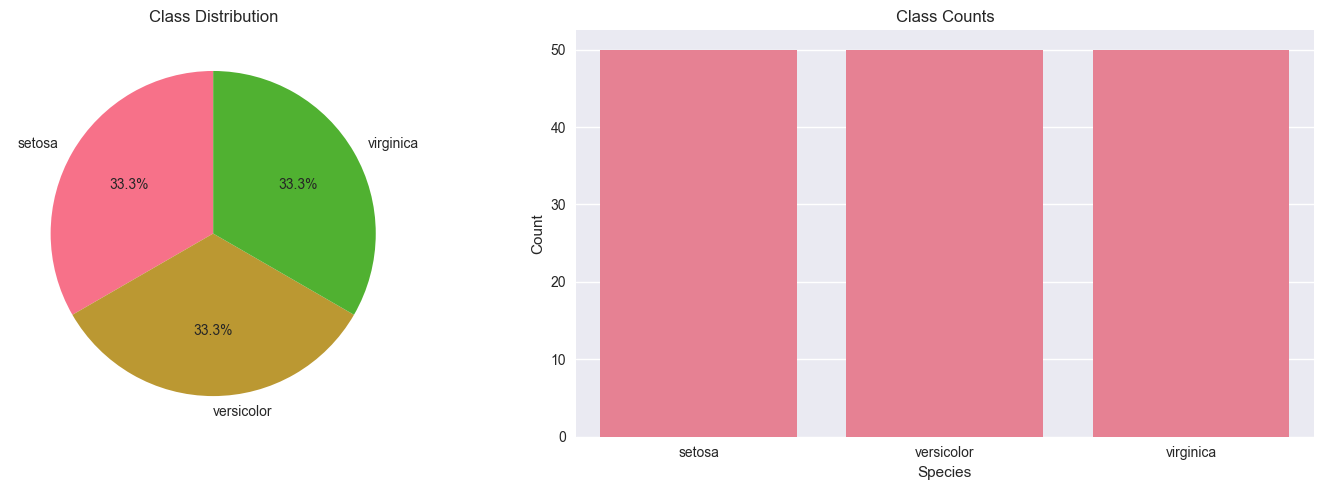

In [3]:
# Class distribution
print("🎯 Class Distribution:")
class_counts = df['target_name'].value_counts()
print(class_counts)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Class distribution pie chart
axes[0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class Distribution')

# Class distribution bar chart
sns.countplot(data=df, x='target_name', ax=axes[1])
axes[1].set_title('Class Counts')
axes[1].set_xlabel('Species')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

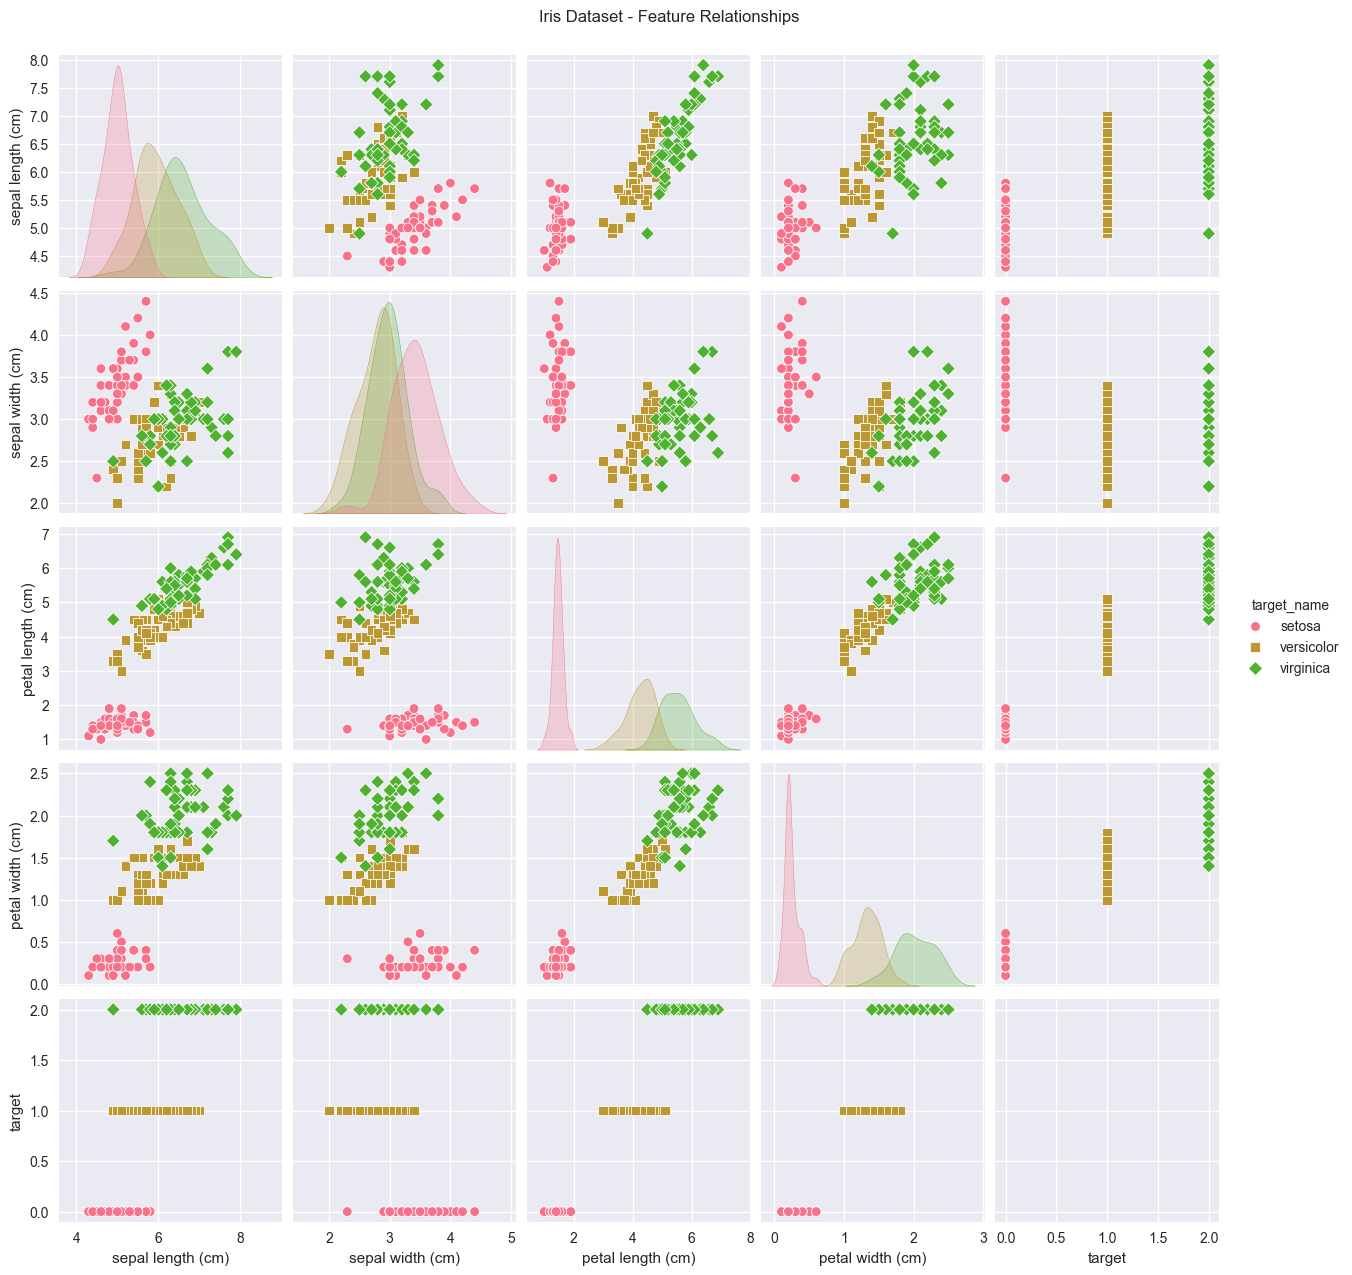

In [4]:
# Feature relationships visualization
plt.figure(figsize=(12, 8))
sns.pairplot(df, hue='target_name', markers=["o", "s", "D"])
plt.suptitle("Iris Dataset - Feature Relationships", y=1.02)
plt.show()

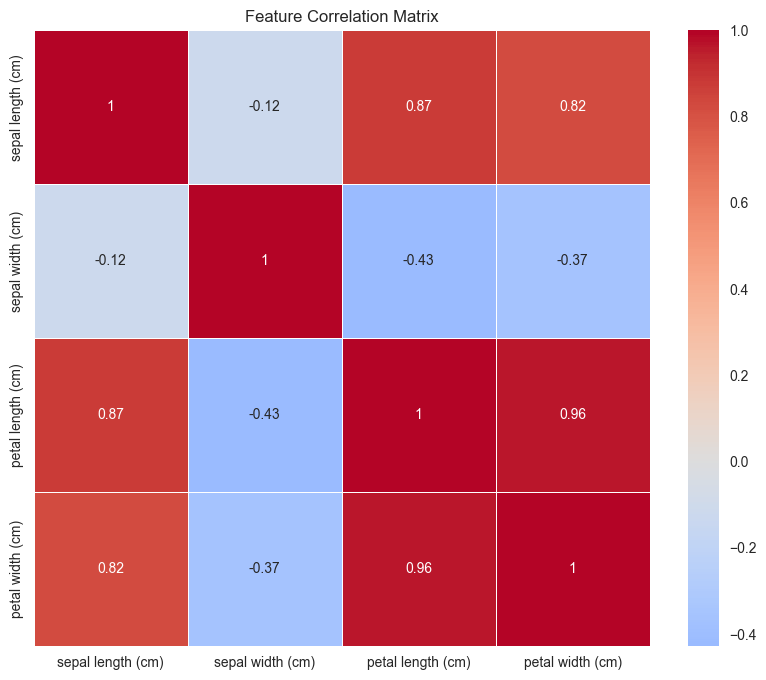

📈 Feature Correlations:
                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


In [5]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[iris.feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

print("📈 Feature Correlations:")
print(correlation_matrix)

## 🤖 Model Training and Evaluation

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"🔧 Data Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

🔧 Data Split:
Training set: 120 samples
Test set: 30 samples
Features: 4


In [7]:
# Train multiple models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=200),
    'SVC': SVC(random_state=42, probability=True)
}

results = {}
print("🚀 Training Models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }
    
    print(f"✅ {name} Accuracy: {accuracy:.4f}")
    print(f"📊 {name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=iris.target_names))
    print("-" * 60)

🚀 Training Models...

Training RandomForest...
✅ RandomForest Accuracy: 0.9000
📊 RandomForest Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

------------------------------------------------------------
Training LogisticRegression...
✅ LogisticRegression Accuracy: 0.9667
📊 LogisticRegression Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
we

🏆 Model Performance Comparison:


,Model,Accuracy
1,LogisticRegression,0.966667
2,SVC,0.966667
0,RandomForest,0.900000


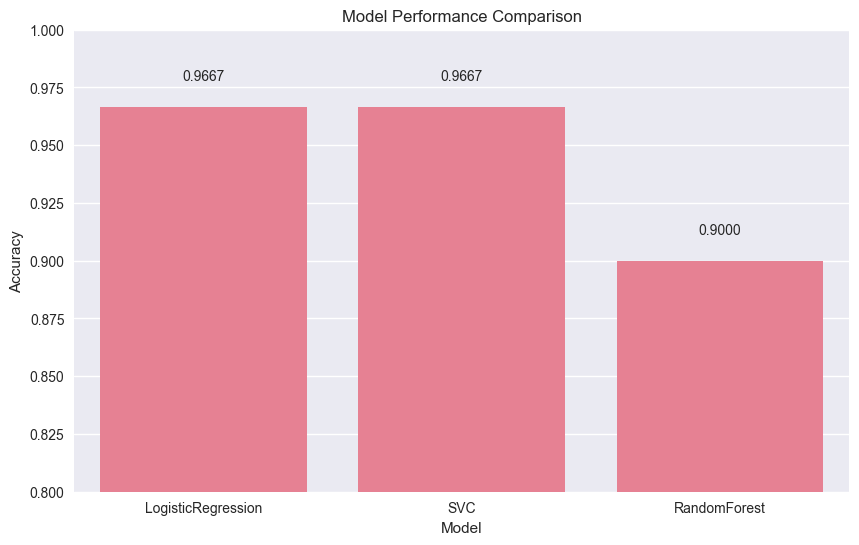


🥇 Best Model: LogisticRegression (Accuracy: 0.9667)


In [8]:
# Compare model performance
model_comparison = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()]
})

model_comparison = model_comparison.sort_values('Accuracy', ascending=False)

print("🏆 Model Performance Comparison:")
display(model_comparison)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=model_comparison, x='Model', y='Accuracy')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
for i, v in enumerate(model_comparison['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.show()

best_model_name = model_comparison.iloc[0]['Model']
best_accuracy = model_comparison.iloc[0]['Accuracy']
print(f"\n🥇 Best Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

## 📈 MLflow Experiment Tracking

In [9]:
# Set up MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("iris_classification")

print("🔬 Setting up MLflow experiment tracking...")
print(f"Experiment: iris_classification")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

2025/09/15 21:51:20 INFO mlflow.tracking.fluent: Experiment with name 'iris_classification' does not exist. Creating a new experiment.


🔬 Setting up MLflow experiment tracking...
Experiment: iris_classification
Tracking URI: http://127.0.0.1:5000


In [15]:
# Log the best model with MLflow
best_model = results[best_model_name]['model']
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

print(f"📊 Logging {best_model_name} to MLflow...")

with mlflow.start_run(run_name=f"iris_{best_model_name}_{timestamp}"):
    # Log parameters
    mlflow.log_param("model_type", best_model_name)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    
    if best_model_name == 'RandomForest':
        mlflow.log_param("n_estimators", best_model.n_estimators)
        mlflow.log_param("max_depth", best_model.max_depth)
    elif best_model_name == 'LogisticRegression':
        mlflow.log_param("max_iter", best_model.max_iter)
        mlflow.log_param("solver", best_model.solver)
    elif best_model_name == 'SVC':
        mlflow.log_param("kernel", best_model.kernel)
        mlflow.log_param("C", best_model.C)
    
    # Log metrics
    mlflow.log_metric("accuracy", best_accuracy)
    mlflow.log_metric("train_samples", X_train.shape[0])
    mlflow.log_metric("test_samples", X_test.shape[0])
    mlflow.log_metric("n_features", X_train.shape[1])
    mlflow.log_metric("n_classes", len(iris.target_names))
    
    # Log model
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="model",
        registered_model_name="iris_classifier"
    )
    
    # Log dataset info
    mlflow.log_text(str(df.describe().to_string()), "dataset_statistics.txt")
    
    print(f"✅ Model {best_model_name} logged successfully!")
    print(f"📊 Accuracy: {best_accuracy:.4f}")
    print(f"🔗 Run ID: {mlflow.active_run().info.run_id}")

📊 Logging LogisticRegression to MLflow...


Successfully registered model 'iris_classifier'.
2025/09/15 22:07:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_classifier, version 1


✅ Model LogisticRegression logged successfully!
📊 Accuracy: 0.9667
🔗 Run ID: 25b65d045bb34f42bc1f6e81dedc5b05


Created version '1' of model 'iris_classifier'.


In [16]:
# Log all models for comparison
print("📊 Logging all models for comparison...\n")

for model_name, model_data in results.items():
    with mlflow.start_run(run_name=f"comparison_{model_name}_{timestamp}"):
        # Log basic parameters
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("test_size", 0.2)
        mlflow.log_param("random_state", 42)
        
        # Log metrics
        mlflow.log_metric("accuracy", model_data['accuracy'])
        
        # Log model
        mlflow.sklearn.log_model(
            sk_model=model_data['model'],
            artifact_path="model"
        )
        
        print(f"✅ {model_name} logged (Accuracy: {model_data['accuracy']:.4f})")

print("\n🎉 All models logged successfully!")

📊 Logging all models for comparison...



c:\Users\xdxd2\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\xdxd2\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


✅ RandomForest logged (Accuracy: 0.9000)
✅ LogisticRegression logged (Accuracy: 0.9667)
✅ SVC logged (Accuracy: 0.9667)

🎉 All models logged successfully!


## 🔍 Model Analysis and Insights

In [18]:
# Feature importance (for RandomForest)
if best_model_name == 'RandomForest':
    feature_importance = pd.DataFrame({
        'feature': iris.feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("🌟 Feature Importance:")
    display(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'{best_model_name} - Feature Importance')
    plt.xlabel('Importance')
    plt.show()

In [20]:
# Make predictions on some sample data
print("🔮 Testing Model Predictions:")
print("\n📝 Sample Predictions:")

# Sample data points
sample_data = np.array([
    [5.1, 3.5, 1.4, 0.2],  # Typical Setosa
    [6.2, 2.9, 4.3, 1.3],  # Typical Versicolor  
    [7.3, 2.9, 6.3, 1.8]   # Typical Virginica
])

sample_predictions = best_model.predict(sample_data)
sample_probabilities = best_model.predict_proba(sample_data)

for i, (features, pred, prob) in enumerate(zip(sample_data, sample_predictions, sample_probabilities)):
    predicted_class = iris.target_names[pred]
    confidence = max(prob)
    
    print(f"Sample {i+1}:")
    print(f"  Features: {features}")
    print(f"  Prediction: {predicted_class}")
    print(f"  Confidence: {confidence:.3f}")
    print(f"  Probabilities: {dict(zip(iris.target_names, prob))}")
    print()

🔮 Testing Model Predictions:

📝 Sample Predictions:
Sample 1:
  Features: [5.1 3.5 1.4 0.2]
  Prediction: setosa
  Confidence: 0.978
  Probabilities: {'setosa': 0.9784004057786007, 'versicolor': 0.021599539138652063, 'virginica': 5.5082747418491126e-08}

Sample 2:
  Features: [6.2 2.9 4.3 1.3]
  Prediction: versicolor
  Confidence: 0.918
  Probabilities: {'setosa': 0.010266144952247553, 'versicolor': 0.9184810874755848, 'virginica': 0.0712527675721677}

Sample 3:
  Features: [7.3 2.9 6.3 1.8]
  Prediction: virginica
  Confidence: 0.973
  Probabilities: {'setosa': 1.1226874424696449e-06, 'versicolor': 0.026805327636229073, 'virginica': 0.9731935496763285}



## 📋 Experiment Summary

In [22]:
print("📊 Experiment Summary")
print("=" * 50)
print(f"📅 Experiment Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Dataset: Iris Flower Classification")
print(f"📈 Samples: {len(X)} total, {len(X_train)} train, {len(X_test)} test")
print(f"🏗️ Features: {len(iris.feature_names)}")
print(f"🎭 Classes: {len(iris.target_names)}")
print(f"\n🤖 Models Trained: {len(models)}")
for name, accuracy in [(k, v['accuracy']) for k, v in results.items()]:
    print(f"  • {name}: {accuracy:.4f}")
print(f"\n🏆 Best Model: {best_model_name}")
print(f"🎯 Best Accuracy: {best_accuracy:.4f}")
print(f"\n📊 MLflow Experiment: iris_classification")
print(f"🔗 Tracking URI: {mlflow.get_tracking_uri()}")
print("\n✅ Experiment completed successfully!")

📊 Experiment Summary
📅 Experiment Date: 2025-09-15 22:16:11
🎯 Dataset: Iris Flower Classification
📈 Samples: 150 total, 120 train, 30 test
🏗️ Features: 4
🎭 Classes: 3

🤖 Models Trained: 3
  • RandomForest: 0.9000
  • LogisticRegression: 0.9667
  • SVC: 0.9667

🏆 Best Model: LogisticRegression
🎯 Best Accuracy: 0.9667

📊 MLflow Experiment: iris_classification
🔗 Tracking URI: http://127.0.0.1:5000

✅ Experiment completed successfully!


## 🚀 Next Steps

1. **Production Pipeline**: Move to structured training pipeline (`application/training/pipelines/`)
2. **Model Serving**: Deploy with BentoML (`application/inference/services/`)
3. **Monitoring**: Set up model monitoring and drift detection
4. **CI/CD**: Implement automated training and deployment
5. **Scaling**: Add more sophisticated models and features

This experiment forms the foundation for your production MLOps system! 🎉